# Build a Stock Price Predictor

### Project Overview:
Stock market prediction can be hard for many people as it's affected by social, economical and political factors.<br> One way to predict the prices is stocks prices analysis which is a method for investors to make buying and selling decisions. there are two ways to do this analysis:

1-Fundamental Analysis: this method relies on studying the financial aspects of business such as financial statements and economic factors to analyze the market value of the shares.<br>

2-Technical Analysis: this method relies on studying the trends and patterns in the historical prices data.<br>

In this project a machine learning approach will be followed. 

#### Dataset:
Dataset used are fetched from Yahoo finance through a python library called "yfinance". Two compaines were used to demonstrate the model.<br>


1-Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage.


<br>
2-Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America and internationally. The company operates through three segments: North America, International, and Amazon Web Services (AWS). It sells merchandise and content purchased for resale from third-party sellers through physical and online stores


### Problem Statement: 

The goal is to develop a robust model to predict stocks prices. the tasks involved are:<br>

1-Fetch the stocks prices data and preprocess it.<br>
2-Do a exploratory data analysis to understand the patterns.<br>
3-Model the date through using two algorithms:Long Short Term Memory
and AutoRegressive Integrated Moving Average.<br>
4-Compare results through metrics discussed in the next section.<br>
5-Deploy the optimal model on a web app.<br>


### Algorithms:

#### ARIMA
ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors

#### LSTM
Long Short Term Memory Network is an advanced RNN, a sequential network, that allows information to persist. It is capable of handling the vanishing gradient problem faced by RNN. A recurrent neural network is also known as RNN is used for persistent memory.

### Metrics: 

A metric is a function that is used to judge the performance of your model.<br>

The metric used to evaluate the performance of both algorithms is Root Mean Sqaure Error(RMSE) Where y’ denotes the predicted value and y denotes the actual value. The number n refers to the total number of values in the test set.This metric is used since the problem is time series prediction.

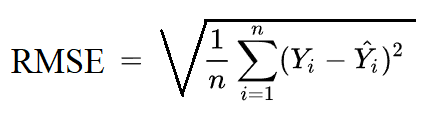

In [1]:
#import libraries 
import yfinance as yf
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings 
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from sklearn.preprocessing import StandardScaler
import math
from keras.models import Sequential
from keras.layers import Dense , LSTM


#to hide warnings 
warnings.filterwarnings("ignore")

In [2]:
#download data
data = yf.download("TSLA AMZN", start="2017-01-01", end="2021-12-20" , group_by = 'ticker')
#multi level columns to single level column
data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

[*********************100%***********************]  2 of 2 completed


In [3]:
#view data
data.head()

,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2017-01-03,AMZN,753.669983,753.669983,758.760010,747.700012,757.919983,3521100
2017-01-03,TSLA,43.397999,43.397999,44.066002,42.192001,42.972000,29616500
2017-01-04,AMZN,757.179993,757.179993,759.679993,754.200012,758.390015,2510500
2017-01-04,TSLA,45.397999,45.397999,45.599998,42.862000,42.950001,56067500
2017-01-05,AMZN,780.450012,780.450012,782.400024,760.260010,761.549988,5830100


In [4]:
#reorder columns
data = data.reindex(columns=['Ticker', 'Close', 'High', 'Low', 'Open', 'Volume' , 'Adj Close'])

## #1: Exploratory Data Analysis

In [5]:
#view data after reordering 
data.head()

,Ticker,Close,High,Low,Open,Volume,Adj Close
Date,,,,,,,
2017-01-03,AMZN,753.669983,758.760010,747.700012,757.919983,3521100,753.669983
2017-01-03,TSLA,43.397999,44.066002,42.192001,42.972000,29616500,43.397999
2017-01-04,AMZN,757.179993,759.679993,754.200012,758.390015,2510500,757.179993
2017-01-04,TSLA,45.397999,45.599998,42.862000,42.950001,56067500,45.397999
2017-01-05,AMZN,780.450012,782.400024,760.260010,761.549988,5830100,780.450012


In [6]:
#checking null values
data.isnull().sum()

Ticker       0
Close        0
High         0
Low          0
Open         0
Volume       0
Adj Close    0
dtype: int64

In [7]:
#checking duplicated values 
data.duplicated().sum()

0

The features included are: <br>

Ticker:The company symbol <br>
Close:The closing recorded price of the equity symbol on the date.<br>High:The highest market price of the equity symbol on the date. <br>Low:The lowest recorded market price of the equity symbol on the date<br>Open: The opening market price of the equity symbol on the date<br>Volume:it measures the number of a stock's shares that are traded on a stock exchange in a day or a period of time <br>Adj Close:the closing price after adjustments for all applicable splits and dividend distributions <br>   

The targeted feature is Adj Close.

In [8]:
#check data types, everything looks fine 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2017-01-03 to 2021-12-17
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     2500 non-null   object 
 1   Close      2500 non-null   float64
 2   High       2500 non-null   float64
 3   Low        2500 non-null   float64
 4   Open       2500 non-null   float64
 5   Volume     2500 non-null   int64  
 6   Adj Close  2500 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 156.2+ KB


the following chart shows the Tesla and Amazon stocks prices from january 2017 until december 2021.<br>
As it can be seen both compaines values have increased as time passes by.For Amazon there has been a significant drop when the pandemic started but it went up again by mid 2020.
Amazon stocks volatility is higher than Tesla's. As for the starting prices, it was around 600USD for Amazon while it was around 50USD for Tesla. the current price for Amazon is approximately 3200USD while it's 700USD for Tesla.


<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

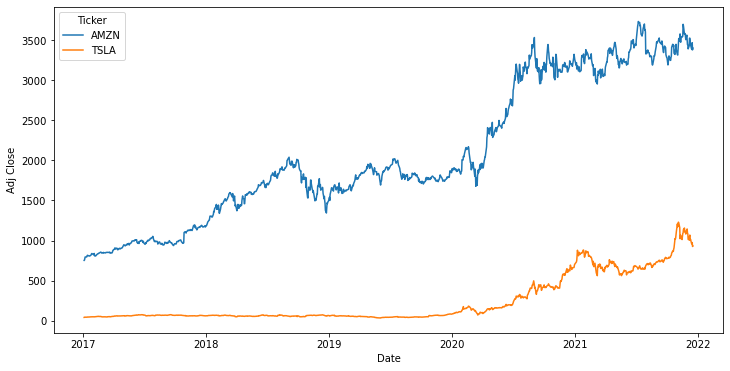

In [9]:
#Visualzing the stocks closing price 
plt.figure(figsize=(12,6))
sns.lineplot(data=data , y='Adj Close' , x='Date' , hue="Ticker" )

<AxesSubplot:xlabel='Ticker', ylabel='Adj Close'>

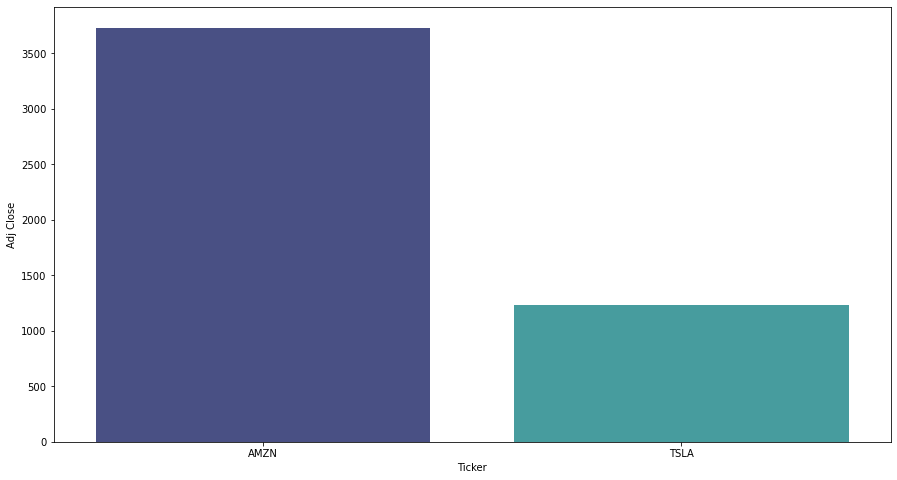

In [10]:
#check highest closing value for each ticker 
max_closed = data['Adj Close'].groupby(data['Ticker']).max()
max_closed = max_closed.reset_index()
plt.figure(figsize=(15,8))
sns.barplot(data = max_closed , x = 'Ticker' , y="Adj Close" , palette="mako")

<AxesSubplot:xlabel='Ticker', ylabel='Adj Close'>

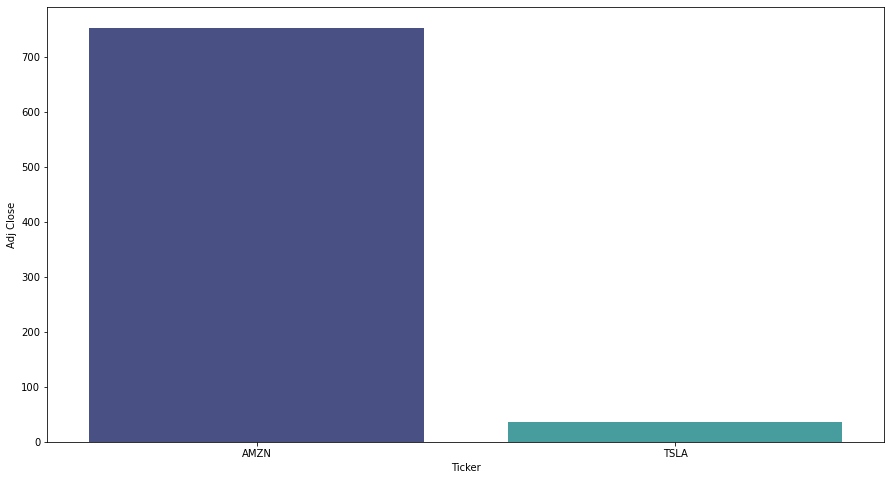

In [11]:
#check lowest closing value for each ticker 
min_closed = data['Adj Close'].groupby(data['Ticker']).min()
min_closed = min_closed.reset_index()
plt.figure(figsize=(15,8))
sns.barplot(data = min_closed , x = 'Ticker' , y="Adj Close" , palette="mako")

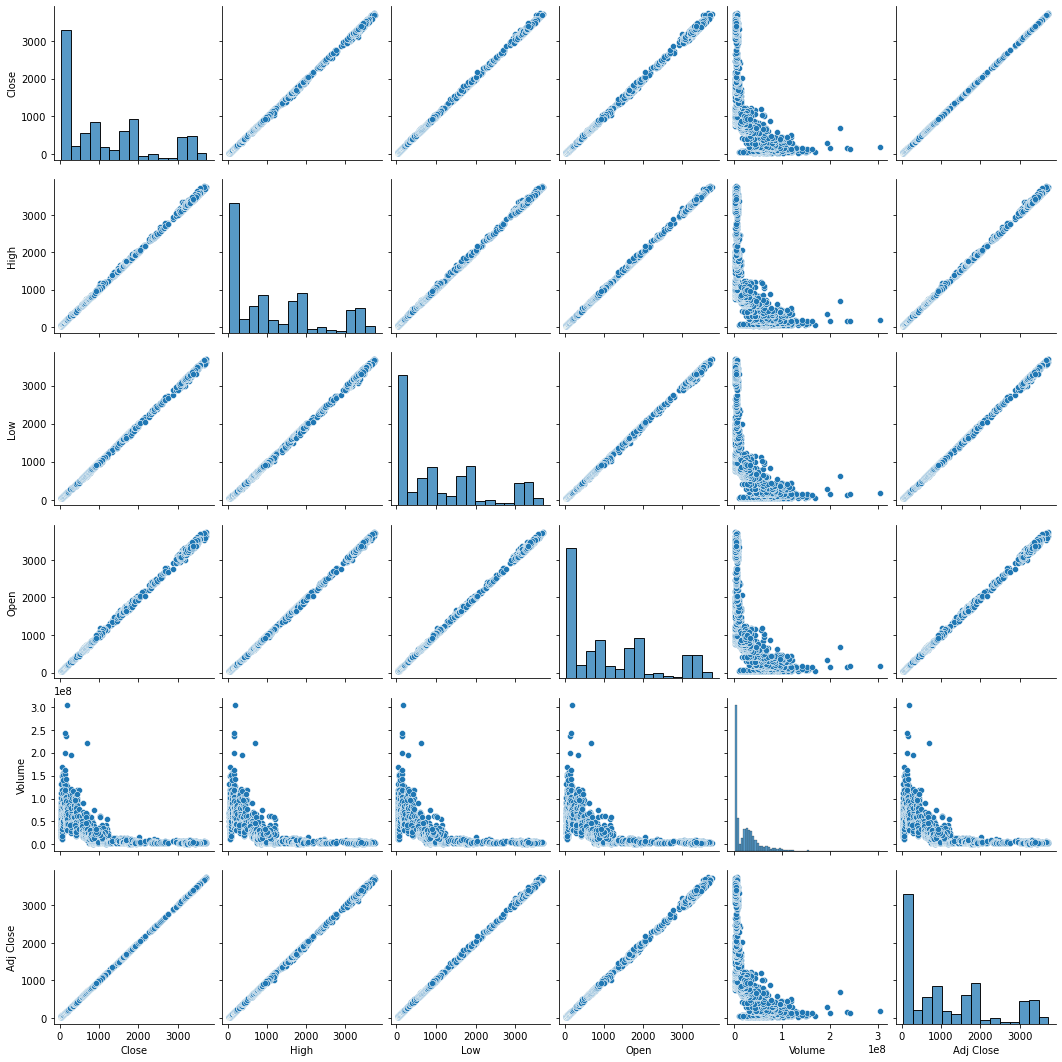

In [12]:
#check correlation between features
sns.pairplot(data = data)

As it can be seen all features are linearly correlated except for the volume.  

In [13]:
# create variable for each ticker
tickers = ['TSLA','AMZN']
for ticker in tickers:
    globals()[ticker] = data[data['Ticker']==ticker]

## #2: Modeling 

# ARIMA

### Amazon stocks prediction using ARIMA

#### check if the data is stationary or not 

Why do we need stationary time series? Because if the time series is not stationary, we can study its behavior only for that time period. Each period of the time series will have its own distinct behavior and it is not possible to predict or generalize for future time periods if the series is not stationary.

In [47]:
#check if the data is stationary or not 

def adf(data):
    """
        This function takes the data and do the augmented Dickey–Fuller test
        null hypothesis is that the data is non stationary
        the alternative hypothesis is that the data is stationary
        Arguments:
            data: the data we want to do the adf test on
     """
    data_adf = adfuller(data['Adj Close'])

    print('ADF Statistic: %f' % data_adf[0])
    print('p-value: %f' % data_adf[1])
    print('Critical Values:')
    for key, value in data_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    

In [48]:
#do the adf test for amazon dataset
adf(AMZN)

ADF Statistic: -0.720998
p-value: 0.841235
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Since the p-value is not less than 0.05 and the test statistic is greater than the critical values the null hypothesis won't be rejected hence the data is non stationary 


#### Choosing the ARIMA order 

Choosing the hyperparameters for the model can be done through auto_arima function which will specify the optimal hyperparameters which are: <br>
p: is the number of autoregressive terms <br>
q: is the number of lagged forecast errors in the prediction equation<br>
d: is the number of nonseasonal differences needed for stationarity<br>

In [49]:
def arima_order(data):
    """
        This function takes the data and select the optimal arima order 
        Arguments:
            data: the data we want to get the optimal arima order for 
        Returns:
            summary: summary of the auto arima order
     """
    auto_order = auto_arima(data, trace=True,
                           suppress_warnings=True)
    return auto_order.summary()

In [50]:
#split the data to training and testing 
y=AMZN['Adj Close']
y_train = y[:982] #80% training
y_test = y[983:] # 20% testing

#get the optimal arima order
arima_order(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9986.957, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9988.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9985.971, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9986.135, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9990.568, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9987.511, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9985.089, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9986.952, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9986.899, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9987.973, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9987.159, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.052 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  982
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4988.545
Date:                Tue, 28 Dec 2021   AIC                           9985.089
Time:                        15:55:00   BIC                          10004.643
Sample:                             0   HQIC                          9992.528
                                - 982                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.8493      1.939      1.986      0.047       0.050       7.649
ar.L1         -0.5972      0.145     -4.110      0.000      -0.882      -0.312
ma.L1          0.5256      0.155      3.391      0.001       0.222       0.829
sigma2      1529.1039     36.386     42.025      0.000    1457.789    1600.419
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1144.55
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               9.22   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

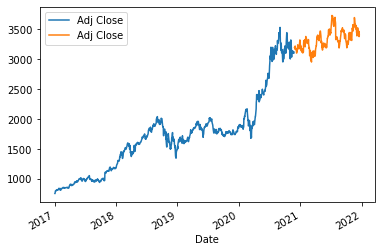

In [51]:
#plot the train and test data
y_train.plot(legend=True)
y_test.plot(legend=True)

In [52]:
#fit the model with the optimal order
model = ARIMA(y_train, order=(1,1,1)).fit()  

In [53]:
#get the test portion length to use it to forecast
len(y_test)

267

In [54]:
#forecast the next 248 records 
forecast = model.forecast(len(y_test))

In [55]:
#set the index of the test data as the index for the forecast data
forecast = forecast.to_frame()
forecast = forecast.set_index(y_test.index)

In [56]:
#re convert it to a series
forecast = forecast['predicted_mean']

The RMSE is considered high

In [57]:
#calculate rmse
arima_rmse = np.sqrt(np.mean(forecast - y_test)**2)
arima_rmse

211.5134661621517

As it can be seen from the following plot. there is a difference between the test values and the predicted values which could indicate that ARIMA might not be the best way to predict stocks prices

<AxesSubplot:title={'center':'Amazon ARIMA model'}, xlabel='Date'>

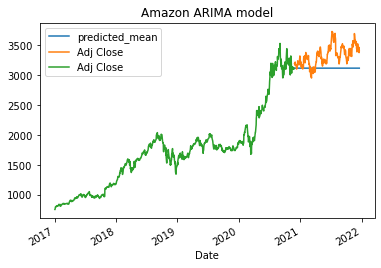

In [58]:
#plot the test , train and predicted 
forecast.plot(legend=True , title='Amazon ARIMA model')
y_test.plot(legend=True)
y_train.plot(legend=True)

### Tesla stocks prediction using ARIMA

Why do we need stationary time series? Because if the time series is not stationary, we can study its behavior only for that time period. Each period of the time series will have its own distinct behavior and it is not possible to predict or generalize for future time periods if the series is not stationary.

In [59]:
#do the adf test for tesla dataset
adf(TSLA)

ADF Statistic: 0.248445
p-value: 0.974852
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Since the p-value is not less than 0.05 and the test statistic is greater than the critical values the null hypothesis won't be rejected hence the data is non stationary

Choosing the hyperparameters for the model can be done through auto_arima function which will specify the optimal hyperparameters which are: <br>
p: is the number of autoregressive terms <br>
q: is the number of lagged forecast errors in the prediction equation<br>
d: is the number of nonseasonal differences needed for stationarity<br>

In [60]:
#split the data to training and testing 
y=TSLA['Adj Close']
y_train = y[:982] # 80% training
y_test = y[983:] # 20% testing

#get the optimal arima order
arima_order(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7379.948, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=7064.981, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=6916.795, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=6876.804, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=6877.749, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6878.757, Time=0.15 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.777 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  982
Model:               SARIMAX(3, 2, 0)   Log Likelihood               -3434.402
Date:                Tue, 28 Dec 2021   AIC                           6876.804
Time:                        15:55:03   BIC                           6896.354
Sample:                             0   HQIC                          6884.242
                                - 982                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8041      0.009    -85.052      0.000      -0.823      -0.786
ar.L2         -0.5318      0.015    -36.225      0.000      -0.561      -0.503
ar.L3         -0.2070      0.010    -19.991      0.000      -0.227      -0.187
sigma2        64.7368      0.931     69.535      0.000      62.912      66.562
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             17357.19
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              61.96   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

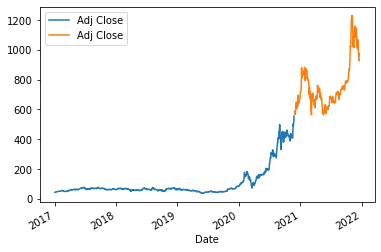

In [61]:
#plot the train and test data
y_train.plot(legend=True)
y_test.plot(legend=True)

In [62]:
#fit the model with the optimal order
model = ARIMA(y_train, order=(3,2,0)).fit()  

In [63]:
#get the test portion length to use it to forecast
len(y_test)

267

In [64]:
#forecast the next 248 records 
forecast = model.forecast(len(y_test))

In [65]:
#set the index of the test data as the index for the forecast data
forecast = forecast.to_frame()
forecast = forecast.set_index(y_test.index)

In [66]:
#re convert it to a series
forecast = forecast['predicted_mean']

the RMSE is too high 

In [67]:
#calculate rmse
arima_rmse = np.sqrt(np.mean(forecast - y_test)**2)
arima_rmse

2790.16709141123

As it can be seen from the following plot. there is a huge difference between the test values and the predicted values which could indicate that ARIMA might not be the best way to predict stocks prices

<AxesSubplot:title={'center':'Tesla ARIMA model'}, xlabel='Date'>

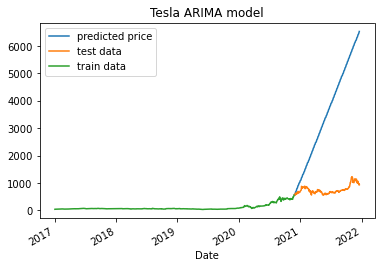

In [68]:
#plot the test , train and predicted 
forecast.plot(legend=True ,label="predicted price" , title='Tesla ARIMA model')
y_test.plot(legend=True ,label="test data")
y_train.plot(legend=True , label="train data")

# Long Short Term Memory

since the results of ARIMA wasn't great another algorithm will be used which is LSTM. 

### Amazon stocks prediction using LSTM

#### preprocessing 

In [31]:
#new dataframe with only the target feature 
amzn_close = AMZN.filter(['Adj Close'])
#convert to numpy array
amzn_close_array = amzn_close.values 

In [32]:
#get training data length 
training_data_length = math.ceil(len(amzn_close_array) * .8)

To prepare the input for the neural network. the data need to be scaled using a scaler, the scaler used is MinMaxScaler in order to obtain values between the range given.
Scaling is used to reduce the complexity of the input so the neural network will learn faster and the accuracy will be better than normal input.

In [33]:
#scale data
scaler = MinMaxScaler (feature_range = (0,1))
scaled_amzn = scaler.fit_transform(amzn_close_array)

In [34]:
#create train data split
train_data = scaled_amzn[0:training_data_length , :]
#split x and y
x_train = []
y_train = []

for i in range (60 , len(train_data)):
    x_train.append(train_data[i-60:i , 0])
    y_train.append(train_data[i,0])
    if i <= 60:
        print(x_train)
        print(y_train)

[array([0.        , 0.00117875, 0.00899341, 0.01421212, 0.01452444,
       0.01418191, 0.01522968, 0.02013945, 0.02131483, 0.018823  ,
       0.01807075, 0.01859464, 0.01835621, 0.02156334, 0.0230947 ,
       0.02782313, 0.02870635, 0.02757126, 0.02576116, 0.02344395,
       0.02642272, 0.028975  , 0.01898421, 0.01812449, 0.0197566 ,
       0.02217791, 0.02273201, 0.02478055, 0.02782649, 0.02777947,
       0.02989852, 0.03038211, 0.03069443, 0.03451276, 0.03423402,
       0.0330855 , 0.03075151, 0.03189333, 0.03068434, 0.03338439,
       0.03198399, 0.03230975, 0.03121159, 0.03101347, 0.03251796,
       0.03335752, 0.03317618, 0.03389149, 0.03319969, 0.03334743,
       0.03349856, 0.0331258 , 0.03469074, 0.03006644, 0.03169854,
       0.03147018, 0.03087577, 0.03128212, 0.03436499, 0.04051731])]
[0.041195687622827826]


In [35]:
#convert the x train and y train data to numpy array
x_train , y_train = np.array(x_train) , np.array(y_train)

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

Samples. One sequence is one sample. A batch is comprised of one or more samples. <br>
Time Steps. One time step is one point of observation in the sample.<br>
Features. One feature is one observation at a time step.

In [36]:
#reshape the data to fit into the lstm input 
# samples number is the train data length , 60 is the time step ,
#and we have only one feature which is the adj closing price
x_train = np.reshape(x_train , (len(x_train), x_train.shape[1] , 1))

 there is no rule of thumb to choose the number of nodes in the network. 

In [37]:
#building the LSTM model
model = Sequential()
model.add(LSTM(50 , return_sequences = True , input_shape = (x_train.shape[1] , 1)))
model.add(LSTM(50 , return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

Adam optimizer is used instead of classical optimizer to update the network weights. 
Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization 
algorithm that can handle sparse gradients on noisy problems.


In [38]:
#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error' , metrics=['accuracy'])

the loss and accuracy is decreasing in as we increase the epochs 

In [39]:
#fitting the model
history = model.fit(x_train , y_train , batch_size=1 , epochs=20)

Epoch 1/20
940/940 [==============================] - 20s 18ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 2/20
940/940 [==============================] - 17s 18ms/step - loss: 9.9419e-04 - accuracy: 0.0000e+00
Epoch 3/20
940/940 [==============================] - 17s 18ms/step - loss: 8.3921e-04 - accuracy: 0.0000e+00
Epoch 4/20
940/940 [==============================] - 17s 18ms/step - loss: 7.4809e-04 - accuracy: 0.0000e+00
Epoch 5/20
940/940 [==============================] - 17s 18ms/step - loss: 7.6528e-04 - accuracy: 0.0000e+00
Epoch 6/20
940/940 [==============================] - 17s 18ms/step - loss: 4.2355e-04 - accuracy: 0.0000e+00
Epoch 7/20
940/940 [==============================] - 17s 18ms/step - loss: 5.4690e-04 - accuracy: 0.0000e+00
Epoch 8/20
940/940 [==============================] - 17s 18ms/step - loss: 3.8122e-04 - accuracy: 0.0000e+00
Epoch 9/20
940/940 [==============================] - 17s 18ms/step - loss: 4.6627e-04 - accuracy: 0.0000e+00
Epoch 10/20
94

In [40]:
print(history.history.keys())


dict_keys(['loss', 'accuracy'])


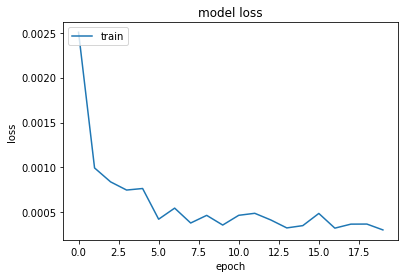

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
#create the testing dataset
#create a new array containing scaled values 
test_data = scaled_amzn[training_data_length - 60 : , :]
#create the datasets x_test , y_test
x_test = []
y_test = amzn_close_array[training_data_length: , :]

for i in range(60 , len(test_data)):
    x_test.append(test_data[i-60:i,0])
    

In [43]:
#convert the data to numpy array
x_test = np.array(x_test)

In [44]:
#reshape the data to 3d 
# samples numbers , time steps , feature count
x_test = np.reshape(x_test , (x_test.shape[0], x_test.shape[1] , 1))

In [45]:
#get the predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

The RMSE is considered low which means the difference between the values of the test set and the predicted values is low. the performence of the model is good

In [46]:
#get root mean squared error
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

4.4108525390625

As it can be seen from the plot, the predicted values is close from the test set values.

In [ ]:
#plot the data
train = AMZN[:training_data_length]
valid = AMZN[training_data_length:]
valid['Predictions'] = predictions 

#visualize 
fig = plt.figure(figsize=(16,8))
plt.title('Amazon model')
plt.xlabel('Data',fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train','Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#show the test set values and predicted values 
valid[['Adj Close' , 'Predictions']]

### Tesla stocks prediction using LSTM

#### preprocessing 

In [15]:
#new dataframe with only the target feature 
tsla_close = TSLA.filter(['Adj Close'])
#convert to numpy array
tsla_close_array = tsla_close.values 

In [16]:
#get training data length 
training_data_length = math.ceil(len(tsla_close_array) * .8)

To prepare the input for the neural network. the data need to be scaled using a scaler, the scaler used is MinMaxScaler in order to obtain values between the range given.
Scaling is used to reduce the complexity of the input so the neural network will learn faster and the accuracy will be better than normal input.

In [17]:
#scale data
scaler = MinMaxScaler (feature_range = (0,1))
scaled_tsla = scaler.fit_transform(tsla_close_array)

In [18]:
#create train data split
train_data = scaled_tsla[0:training_data_length , :]
#split x and y
x_train = []
y_train = []

for i in range (60 , len(train_data)):
    x_train.append(train_data[i-60:i , 0])
    y_train.append(train_data[i,0])
    if i <= 60:
        print(x_train)
        print(y_train)

[array([0.00636789, 0.00804277, 0.00800257, 0.00838109, 0.00876129,
       0.00852513, 0.00850169, 0.00847824, 0.00984494, 0.00948149,
       0.00994711, 0.01085154, 0.01101401, 0.01171578, 0.01266879,
       0.01264534, 0.01231706, 0.01239076, 0.01200218, 0.01221992,
       0.01176938, 0.01215627, 0.01211943, 0.01319805, 0.01314948,
       0.01391992, 0.01511244, 0.01511746, 0.0170218 , 0.01708544,
       0.01688111, 0.01507056, 0.01561992, 0.01648416, 0.01583431,
       0.01289992, 0.01306908, 0.01126524, 0.01189499, 0.01190002,
       0.01197706, 0.01215962, 0.01209933, 0.01166051, 0.01137243,
       0.01104248, 0.01083982, 0.01125519, 0.01323657, 0.01285637,
       0.0139149 , 0.01382278, 0.01389312, 0.01201056, 0.01273578,
       0.01269726, 0.01410081, 0.01528327, 0.01649421, 0.01648249])]
[0.016572929537689497]


In [19]:
#convert the x train and y train data to numpy array
x_train , y_train = np.array(x_train) , np.array(y_train)

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

Samples. One sequence is one sample. A batch is comprised of one or more samples. <br>
Time Steps. One time step is one point of observation in the sample.<br>
Features. One feature is one observation at a time step.

In [20]:
#reshape the data to fit into the lstm input 
# samples number is the train data length , 60 is the time step ,
#and we have only one feature which is the adj closing price
x_train = np.reshape(x_train , (len(x_train), x_train.shape[1] , 1))

In [21]:
#building the LSTM model
model = Sequential()
model.add(LSTM(50 , return_sequences = True , input_shape = (x_train.shape[1] , 1)))
model.add(LSTM(50 , return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

the loss and accuracy is decreasing in as we increase the epochs 

In [23]:
#fitting the model
history2 = model.fit(x_train , y_train , batch_size=1 , epochs=20)

Epoch 1/20
940/940 [==============================] - 20s 19ms/step - loss: 6.5605e-04
Epoch 2/20
940/940 [==============================] - 17s 18ms/step - loss: 3.8255e-04
Epoch 3/20
940/940 [==============================] - 17s 18ms/step - loss: 2.7113e-04
Epoch 4/20
940/940 [==============================] - 17s 18ms/step - loss: 2.7884e-04
Epoch 5/20
940/940 [==============================] - 17s 18ms/step - loss: 1.7422e-04
Epoch 6/20
940/940 [==============================] - 21s 22ms/step - loss: 2.3807e-04
Epoch 7/20
940/940 [==============================] - 18s 19ms/step - loss: 2.0955e-04
Epoch 8/20
940/940 [==============================] - 17s 18ms/step - loss: 1.7446e-04
Epoch 9/20
940/940 [==============================] - 17s 18ms/step - loss: 1.6455e-04
Epoch 10/20
940/940 [==============================] - 17s 18ms/step - loss: 1.7069e-04
Epoch 11/20
940/940 [==============================] - 17s 19ms/step - loss: 1.5075e-04
Epoch 12/20
940/940 [====================

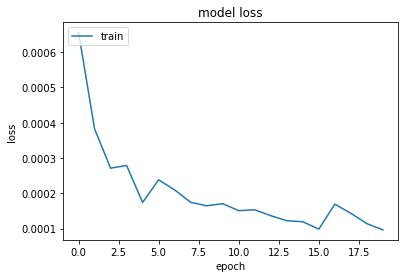

In [24]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
#create the testing dataset
#create a new array containing scaled values 
test_data = scaled_tsla[training_data_length - 60 : , :]
#create the datasets x_test , y_test
x_test = []
y_test = tsla_close_array[training_data_length: , :]

for i in range(60 , len(test_data)):
    x_test.append(test_data[i-60:i,0])
    

In [26]:
#convert the data to numpy array
x_test = np.array(x_test)

In [27]:
#reshape the data to 3d 
# samples numbers , time steps , feature count
x_test = np.reshape(x_test , (x_test.shape[0], x_test.shape[1] , 1))

In [28]:
#get the predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

the model did better in Amazon dataset but still the RMSE is considered low 

In [29]:
#get root mean squared error
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

31.1265263671875

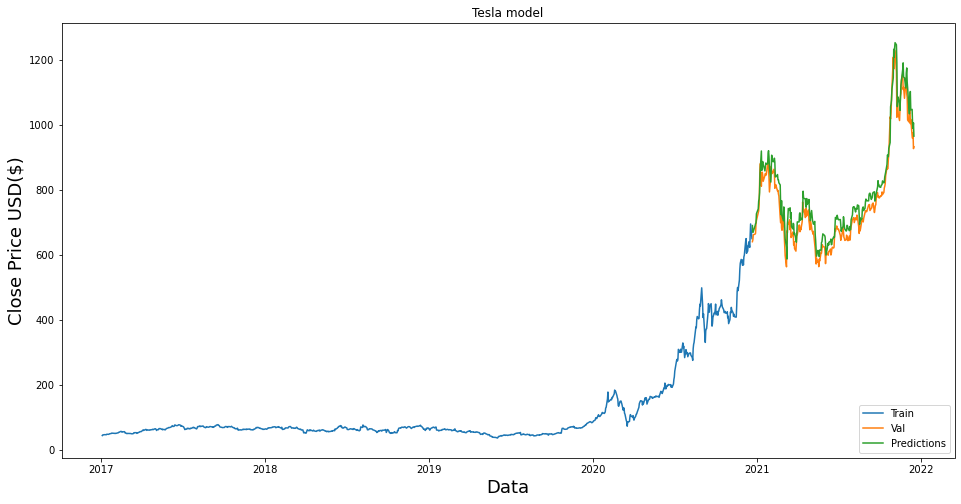

In [30]:
#plot the data
train = TSLA[:training_data_length]
valid = TSLA[training_data_length:]
valid['Predictions'] = predictions 

#visualize 
fig = plt.figure(figsize=(16,8))
plt.title('Tesla model')
plt.xlabel('Data',fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train','Val', 'Predictions'], loc='lower right')
plt.show()